In [159]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB

In [160]:
train = pd.read_csv("twitter_training.csv", header=None)
train.columns = ["id", "Company", "Sentiment", "Review"]
train.drop(columns=["id", "Company"], inplace=True)
sentiments = ['Negative', 'Neutral', 'Positive']
train = train[train.Sentiment != 'Irrelevant']
train

,Sentiment,Review
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


,Review
Sentiment,
Negative,22358
Neutral,18108
Positive,20655


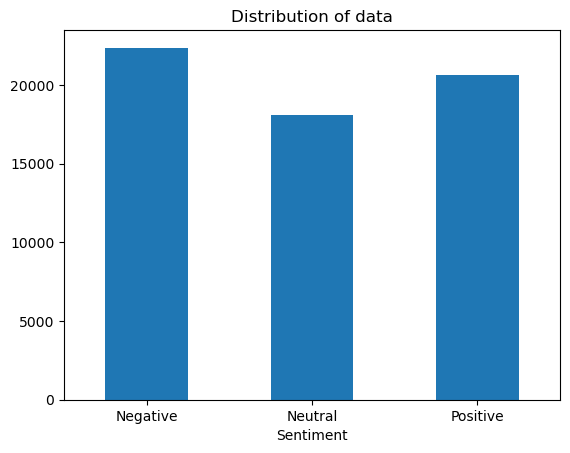

In [161]:
ax = train.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(sentiments, rotation=0)
# Storing data in lists.
text, sentiment = list(train['Review']), list(train['Sentiment'])
train.groupby('Sentiment').count()

In [162]:
train['Sentiment'] = train['Sentiment'].replace(['Negative', 'Neutral', 'Positive'], [0, -1, 1])
train

,Sentiment,Review
0,1,im getting on borderlands and i will murder yo...
1,1,I am coming to the borders and I will kill you...
2,1,im getting on borderlands and i will kill you ...
3,1,im coming on borderlands and i will murder you...
4,1,im getting on borderlands 2 and i will murder ...
...,...,...
74677,1,Just realized that the Windows partition of my...
74678,1,Just realized that my Mac window partition is ...
74679,1,Just realized the windows partition of my Mac ...
74680,1,Just realized between the windows partition of...


In [163]:
data_pos = train[train['Sentiment'] == 1]
data_neg = train[train['Sentiment'] == 0]
data_neu = train[train['Sentiment'] == -1]
data_pos

,Sentiment,Review
0,1,im getting on borderlands and i will murder yo...
1,1,I am coming to the borders and I will kill you...
2,1,im getting on borderlands and i will kill you ...
3,1,im coming on borderlands and i will murder you...
4,1,im getting on borderlands 2 and i will murder ...
...,...,...
74677,1,Just realized that the Windows partition of my...
74678,1,Just realized that my Mac window partition is ...
74679,1,Just realized the windows partition of my Mac ...
74680,1,Just realized between the windows partition of...


In [164]:
dataset = pd.concat([data_pos, data_neg])
dataset

,Sentiment,Review
0,1,im getting on borderlands and i will murder yo...
1,1,I am coming to the borders and I will kill you...
2,1,im getting on borderlands and i will kill you ...
3,1,im coming on borderlands and i will murder you...
4,1,im getting on borderlands 2 and i will murder ...
...,...,...
74665,0,Nvidia really delayed the 3070 by 2 weeks.
74666,0,Nvidia did delay by 3070 2 weeks.
74667,0,Nvidia really delayed the 3070 several weeks.
74668,0,Nvidia really only delayed the 3070 2 flight w...


In [165]:
dataset['Review'] = dataset['Review'].str.lower()
dataset['Review'].head()

0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
2    im getting on borderlands and i will kill you ...
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
Name: Review, dtype: object

In [166]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'im', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [167]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['Review'] = dataset['Review'].apply(lambda text: cleaning_stopwords(text))
dataset['Review'].head()

0         getting borderlands murder ,
1             coming borders kill all,
2        getting borderlands kill all,
3       coming borderlands murder all,
4    getting borderlands 2 murder all,
Name: Review, dtype: object

In [168]:
import string
import re
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['Review']= dataset['Review'].apply(lambda x: cleaning_punctuations(x))

In [169]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['Review'] = dataset['Review'].apply(lambda x: cleaning_numbers(x))
dataset['Review'].head()

0        getting borderlands murder 
1            coming borders kill all
2       getting borderlands kill all
3      coming borderlands murder all
4    getting borderlands  murder all
Name: Review, dtype: object

In [170]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['Review'] = dataset['Review'].apply(lambda x: cleaning_URLs(x))
dataset['Review'].tail()

74665           nvidia really delayed   weeks
74666                    nvidia delay   weeks
74667    nvidia really delayed  several weeks
74668    nvidia really delayed   flight weeks
74669       nvidia really delayed next  weeks
Name: Review, dtype: object

In [171]:
X=dataset.Review
y=dataset.Sentiment

In [172]:
dataset

,Sentiment,Review
0,1,getting borderlands murder
1,1,coming borders kill all
2,1,getting borderlands kill all
3,1,coming borderlands murder all
4,1,getting borderlands murder all
...,...,...
74665,0,nvidia really delayed weeks
74666,0,nvidia delay weeks
74667,0,nvidia really delayed several weeks
74668,0,nvidia really delayed flight weeks


In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =26105112)

In [174]:
data = pd.concat([X_train, X_test])
data = pd.DataFrame(data, columns=['Review'])
data

,Review
21712,shit crazy
11664,sht smooth 🤣
2133,were excited talking new things coming borderl...
13167,dont yall think dame shoulda made next gen zi...
1115,yo epic giveawayunk proceeds gift twitch subs...
...,...
32988,sometimes fortnite pisses off
10956,its beautiful
38948,come help us make report today moscow time i...
19744,wake practically reread high priests slow chan...


In [175]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, LSTM, Dropout, Embedding, Dense, Bidirectional,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, CategoricalAccuracy, Recall

In [176]:
words = data.Review.values

tokenizer = Tokenizer(num_words=500000)
tokenizer.fit_on_texts(words)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(words)
padded_sequence = pad_sequences(encoded_docs, maxlen=60)

In [177]:
len(X_train)

39036

In [178]:
model = Sequential([
    Embedding(vocab_size, 32, input_length = 60),
    LSTM(64,activation = 'tanh'),
    Dense(128,activation = 'relu'),
    Dense(64,activation = 'relu'),
    Dense(32,activation = 'relu'),
    Dense(1,activation = 'sigmoid')
])

model.compile(loss = 'BinaryCrossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 60, 32)            733696    
                                                                 
 lstm_10 (LSTM)              (None, 64)                24832     
                                                                 
 dense_32 (Dense)            (None, 128)               8320      
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 777,217
Trainable params: 777,217
Non-t

In [179]:
history = model.fit(padded_sequence[:len(X_train)], y_train, validation_split=0.1, epochs=10, batch_size=32)

Epoch 1/10


C:\Users\devsh\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1098/1098 [==============================] - 156s 134ms/step - loss: 0.4898 - accuracy: 0.7470 - val_loss: 0.3374 - val_accuracy: 0.8614
Epoch 2/10
1098/1098 [==============================] - 145s 132ms/step - loss: 0.2596 - accuracy: 0.8927 - val_loss: 0.2522 - val_accuracy: 0.8986
Epoch 3/10
1098/1098 [==============================] - 146s 133ms/step - loss: 0.1825 - accuracy: 0.9252 - val_loss: 0.2223 - val_accuracy: 0.9075
Epoch 4/10
1098/1098 [==============================] - 145s 132ms/step - loss: 0.1421 - accuracy: 0.9423 - val_loss: 0.2183 - val_accuracy: 0.9088
Epoch 5/10
1098/1098 [==============================] - 146s 133ms/step - loss: 0.1178 - accuracy: 0.9506 - val_loss: 0.2100 - val_accuracy: 0.9170
Epoch 6/10
1098/1098 [==============================] - 147s 134ms/step - loss: 0.1033 - accuracy: 0.9555 - val_loss: 0.2197 - val_accuracy: 0.9144
Epoch 7/10
1098/1098 [==============================] - 148s 135ms/step - loss: 0.0927 - accuracy: 0.9590 - val_loss: 0.218

In [180]:
pred = []
count = 0
for array in padded_sequence[len(X_train):]:
    if count % 100 == 0:
        print(count)
    count += 1
    prediction = int(model.predict(array.reshape(1, 60)).round())
    pred.append(prediction)
pred

0
1/1 [==============================] - 0s 63ms/step
100
1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 63ms/step
200
1/1 [==============================] - 0s 48ms/step
300
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 63ms/step
400
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 64ms/step
500
1/1 [==============================] - 0s 62ms/step
600
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 62ms/step
700
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step
800
1/1 [==============================] - 0s 62ms/step
900
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 51ms/step
1000
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step
1100
1/1 [==============================] - 0s 63ms/step
1200
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 56ms/step
1300
1/1 [==============================] - 0s 63ms/step
1400
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 64ms/step
1500
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 79ms/step
1600
1/1 [==============================] - 0s 63ms/step
1700
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 78ms/step
1800
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 47ms/step
1900
1/1 [==============================] - 0s 63ms/step
2000
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 46ms/step
2100
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 63ms/step
2200
1/1 [==============================] - 0s 56ms/step
2300
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 63ms/step
2400
1/1 [==============================] - 0s 63ms/step
2500
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step
2600
1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 63ms/step
2700
1/1 [==============================] - 0s 25ms/step
2800
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 18ms/step
2900
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 32ms/step
3000
1/1 [==============================] - 0s 17ms/step
3100
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step
3200
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 14ms/step
3300
1/1 [==============================] - 0s 25ms/step
3400
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step
3500
1/1 [==============================] - 0s 28ms/step
3600
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
3700
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
3800
1/1 [==============================] - 0s 19ms/step
3900
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 34ms/step
4000
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step
4100
1/1 [==============================] - 0s 17ms/step
4200
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 32ms/step
4300
1/1 [==============================] - 0s 23ms/step


[0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,


              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2285
           1       0.91      0.92      0.92      2053

    accuracy                           0.92      4338
   macro avg       0.92      0.92      0.92      4338
weighted avg       0.92      0.92      0.92      4338



Text(0.5, 1.0, 'Confusion Matrix')

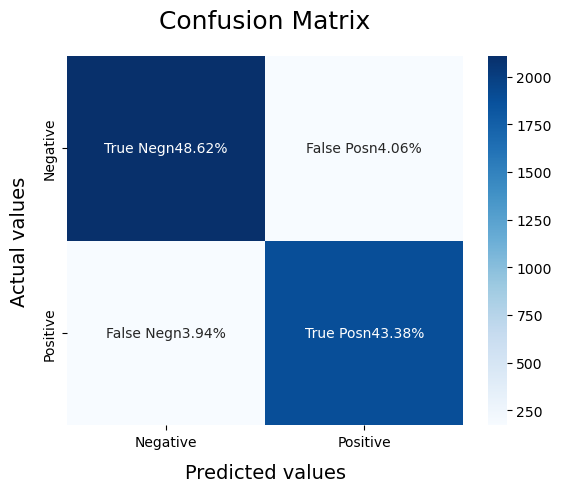

In [181]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
cf_matrix = confusion_matrix(y_test, pred)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [182]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32, input_length=60),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'BinaryCrossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 60, 32)            733696    
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 128)          49664     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 1)               

In [183]:
history = model.fit(padded_sequence[:len(X_train)], y_train, validation_split=0.1, epochs=10, batch_size=32)

Epoch 1/10


C:\Users\devsh\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1098/1098 [==============================] - 412s 362ms/step - loss: 0.4868 - accuracy: 0.7386 - val_loss: 0.3469 - val_accuracy: 0.8560
Epoch 2/10
1098/1098 [==============================] - 472s 430ms/step - loss: 0.2532 - accuracy: 0.8968 - val_loss: 0.2486 - val_accuracy: 0.9034
Epoch 3/10
1098/1098 [==============================] - 473s 431ms/step - loss: 0.1766 - accuracy: 0.9299 - val_loss: 0.2189 - val_accuracy: 0.9119
Epoch 4/10
1098/1098 [==============================] - 403s 367ms/step - loss: 0.1367 - accuracy: 0.9446 - val_loss: 0.2027 - val_accuracy: 0.9201
Epoch 5/10
1098/1098 [==============================] - 357s 325ms/step - loss: 0.1136 - accuracy: 0.9525 - val_loss: 0.2017 - val_accuracy: 0.9206
Epoch 6/10
1098/1098 [==============================] - 338s 307ms/step - loss: 0.0981 - accuracy: 0.9566 - val_loss: 0.2004 - val_accuracy: 0.9196
Epoch 7/10
1098/1098 [==============================] - 346s 315ms/step - loss: 0.0877 - accuracy: 0.9616 - val_loss: 0.207

In [184]:
pred = []
count = 0
for array in padded_sequence[len(X_train):]:
    if count % 100 == 0:
        print(count)
    count += 1
    prediction = int(model.predict(array.reshape(1, 60)).round())
    pred.append(prediction)
pred

0
1/1 [==============================] - 0s 29ms/step
100
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step
200
1/1 [==============================] - 0s 31ms/step
300
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
400
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
500
1/1 [==============================] - 0s 31ms/step
600
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
700
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
800
1/1 [==============================] - 0s 31ms/step
900
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
1000
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
1100
1/1 [==============================] - 0s 31ms/step
1200
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
1300
1/1 [==============================] - 0s 31ms/step
1400
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
1500
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
1600
1/1 [==============================] - 0s 31ms/step
1700
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
1800
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step
1900
1/1 [==============================] - 0s 31ms/step
2000
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
2100
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
2200
1/1 [==============================] - 0s 35ms/step
2300
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step
2400
1/1 [==============================] - 0s 31ms/step
2500
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
2600
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step
2700
1/1 [==============================] - 0s 31ms/step
2800
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step
2900
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step
3000
1/1 [==============================] - 0s 37ms/step
3100
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 32ms/step
3200
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step
3300
1/1 [==============================] - 0s 35ms/step
3400
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 22ms/step
3500
1/1 [==============================] - 0s 28ms/step
3600
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step
3700
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step
3800
1/1 [==============================] - 0s 39ms/step
3900
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step
4000
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 41ms/step
4100
1/1 [==============================] - 0s 31ms/step
4200
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
4300
1/1 [==============================] - 0s 27ms/step


[0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,


              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2285
           1       0.89      0.94      0.91      2053

    accuracy                           0.92      4338
   macro avg       0.92      0.92      0.92      4338
weighted avg       0.92      0.92      0.92      4338



Text(0.5, 1.0, 'Confusion Matrix')

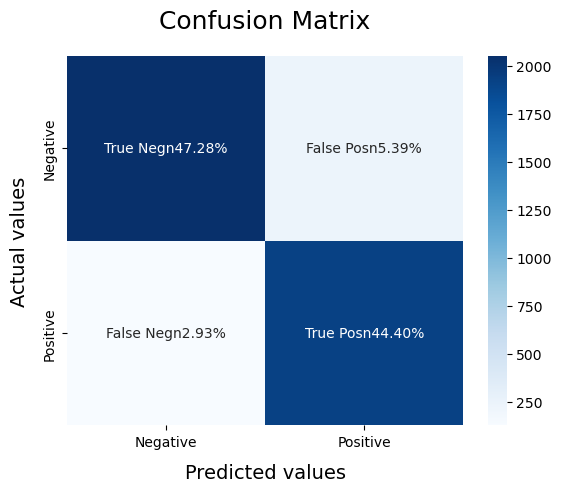

In [185]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
cf_matrix = confusion_matrix(y_test, pred)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [186]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32, input_length=60),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss = 'BinaryCrossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 60, 32)            733696    
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              37632     
 nal)                                                            
                                                                 
 dense_39 (Dense)            (None, 128)               16512     
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 32)                2080      
                                                                 
 dense_42 (Dense)            (None, 1)                 33        
                                                     

In [187]:
history = model.fit(padded_sequence[:len(X_train)], y_train, validation_split=0.1, epochs=10, batch_size=32)

Epoch 1/10


C:\Users\devsh\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1098/1098 [==============================] - 117s 102ms/step - loss: 0.4893 - accuracy: 0.7382 - val_loss: 0.3331 - val_accuracy: 0.8581
Epoch 2/10
1098/1098 [==============================] - 117s 106ms/step - loss: 0.2475 - accuracy: 0.8962 - val_loss: 0.2548 - val_accuracy: 0.8922
Epoch 3/10
1098/1098 [==============================] - 118s 108ms/step - loss: 0.1713 - accuracy: 0.9293 - val_loss: 0.2137 - val_accuracy: 0.9091
Epoch 4/10
1098/1098 [==============================] - 116s 106ms/step - loss: 0.1346 - accuracy: 0.9444 - val_loss: 0.2039 - val_accuracy: 0.9188
Epoch 5/10
1098/1098 [==============================] - 117s 106ms/step - loss: 0.1109 - accuracy: 0.9522 - val_loss: 0.2036 - val_accuracy: 0.9193
Epoch 6/10
1098/1098 [==============================] - 114s 104ms/step - loss: 0.0995 - accuracy: 0.9568 - val_loss: 0.2109 - val_accuracy: 0.9247
Epoch 7/10
1098/1098 [==============================] - 116s 105ms/step - loss: 0.0891 - accuracy: 0.9599 - val_loss: 0.218

In [188]:
pred = []
count = 0
for array in padded_sequence[len(X_train):]:
    if count % 100 == 0:
        print(count)
    count += 1
    prediction = int(model.predict(array.reshape(1, 60)).round())
    pred.append(prediction)
pred

0
1/1 [==============================] - 0s 30ms/step
100
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
200
1/1 [==============================] - 0s 25ms/step
300
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
400
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step
500
1/1 [==============================] - 0s 15ms/step
600
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 26ms/step
700
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step
800
1/1 [==============================] - 0s 28ms/step
900
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step
1000
1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 21ms/step
1100
1/1 [==============================] - 0s 22ms/step
1200
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step
1300
1/1 [==============================] - 0s 31ms/step
1400
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step
1500
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 17ms/step
1600
1/1 [==============================] - 0s 20ms/step
1700
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step
1800
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 20ms/step
1900
1/1 [==============================] - 0s 17ms/step
2000
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step
2100
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step
2200
1/1 [==============================] - 0s 30ms/step
2300
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 27ms/step
2400
1/1 [==============================] - 0s 24ms/step
2500
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 34ms/step
2600
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 28ms/step
2700
1/1 [==============================] - 0s 30ms/step
2800
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step
2900
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step
3000
1/1 [==============================] - 0s 24ms/step
3100
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step
3200
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 25ms/step
3300
1/1 [==============================] - 0s 41ms/step
3400
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 21ms/step
3500
1/1 [==============================] - 0s 31ms/step
3600
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 32ms/step
3700
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step
3800
1/1 [==============================] - 0s 29ms/step
3900
1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 25ms/step
4000
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 21ms/step
4100
1/1 [==============================] - 0s 18ms/step
4200
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step
4300
1/1 [==============================] - 0s 31ms/step


[0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,


              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2285
           1       0.93      0.88      0.91      2053

    accuracy                           0.91      4338
   macro avg       0.92      0.91      0.91      4338
weighted avg       0.92      0.91      0.91      4338



Text(0.5, 1.0, 'Confusion Matrix')

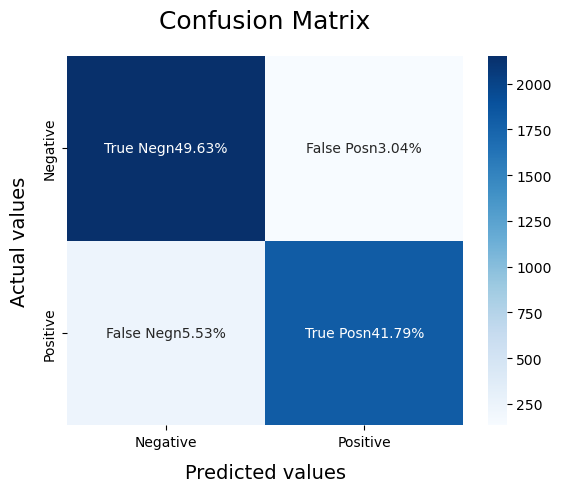

In [189]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
cf_matrix = confusion_matrix(y_test, pred)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)